In [1]:
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from skimage import restoration
from lenstronomy.Data.psf import PSF

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleSkyPyLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, lenstronomy_sim, pandeia_input, convert, bkg, psf

In [2]:
band = 'f106'
lens = SampleSkyPyLens()
model = lens.get_array(num_pix=51, side=5.61)
model += lenstronomy_sim.get_background_noise(lens, model, band)

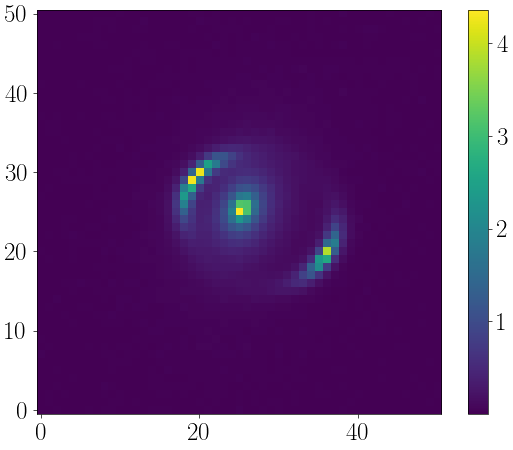

In [3]:
plot.plot(model, colorbar=True)

In [4]:
calc, _ = pandeia_input.build_pandeia_calc(model, lens, background=False, band=band, max_scene_size=5, num_samples=10000, suppress_output=False)

image, _ = pandeia_input.get_pandeia_image(calc)

  0%|          | 0/1555 [00:00<?, ?it/s]

100%|██████████| 1555/1555 [00:09<00:00, 164.25it/s]


Point source conversion complete: placed 1555 point sources
Estimated calculation time: 0:02:02
Performing Pandeia calculation...
Pandeia calculation complete in 0:02:09


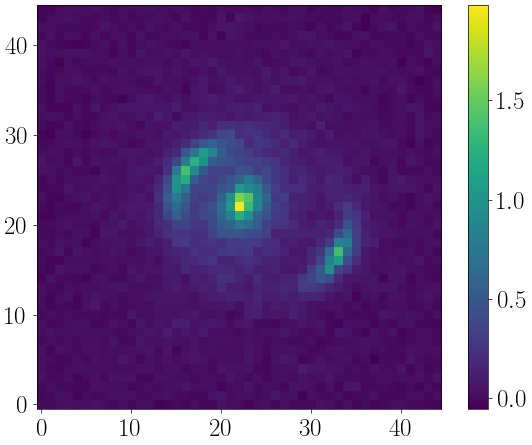

In [5]:
plot.plot(image, colorbar=True)

In [6]:
kernel = psf.load_psf(os.path.join(repo_dir, 'mejiro', 'data', 'webbpsf_f106.fits'))

In [7]:
resized = PSF(**psf.get_kwargs_psf(kernel, 5)).kernel_pixel

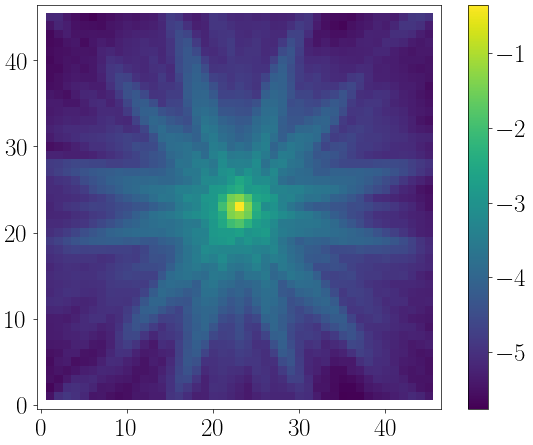

In [12]:
plot.log10(resized, colorbar=True)

In [13]:
deconvolved_RL = restoration.richardson_lucy(image, resized, num_iter=50, clip=False)

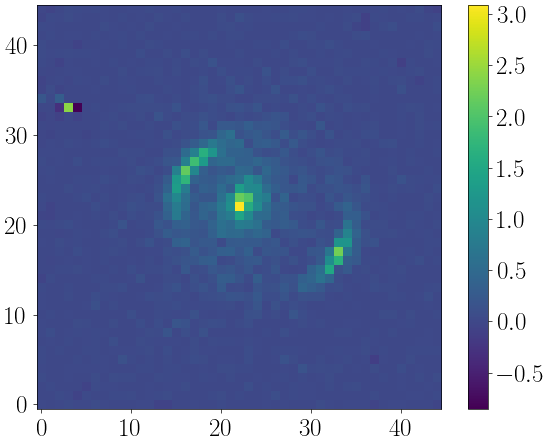

In [14]:
plot.plot(deconvolved_RL, colorbar=True)

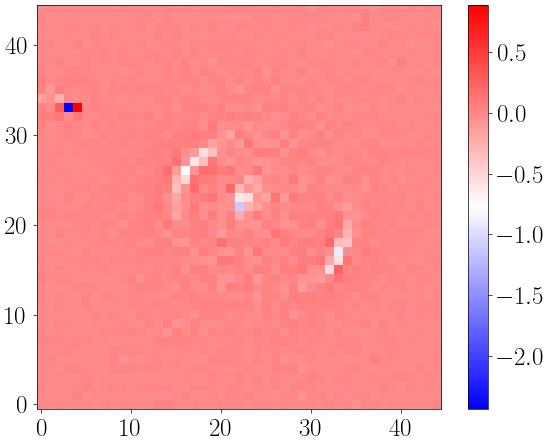

In [15]:
plot.plot(image - deconvolved_RL, cmap='bwr', colorbar=True)